## Imports and read data

In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, plot_confusion_matrix

In [30]:
everything = pd.read_csv('data/cleaned/epa_nih_county_join_20221111.csv')

## Feature engineer target variable

In [31]:
everything['is_rising'] = 0
everything.loc[everything['Recent Trend'] == 'rising', 'is_rising'] = 1

In [32]:
everything['is_rising'].value_counts()

0    22174
1     6182
Name: is_rising, dtype: int64

In [7]:
everything['Recent Trend'].value_counts()

stable                18225
rising                 6182
falling                2703
*                       743
data not available      503
Name: Recent Trend, dtype: int64

In [8]:
everything.head()

,PARENT_ADDRESS,NUMBER_ID_CODE,Latitude,CHEMICAL_NAME,PARENT_STATE,SITE_ADDRESS,CHEMICAL_ID_NUMBER,FAC_DET_REP,Public_CDR_SUBMISSIONS_SITE_NAME,SITE_ZIP,...,Upper 95% Confidence Interval,CI*Rank([rank note]),Lower CI (CI*Rank),Upper CI (CI*Rank),Average Annual Count,Recent Trend,Recent 5-Year Trend ([trend note]) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1,is_rising
0,2020 Dow Center,CASRN,30.322311,"Ethene, Chloro-",MI,21145 Highway 1,000075-01-4,http://iaspub.epa.gov/enviro/fii_query_dtl.dis...,The Dow Chemical Company,70764,...,138.6,N/A,2,59,24,stable,0.4,-1.1,1.9,0
1,2020 Dow Center,CASRN,30.322311,"1,2-Propanediol",MI,21145 Highway 1,000057-55-6,http://iaspub.epa.gov/enviro/fii_query_dtl.dis...,The Dow Chemical Company,70764,...,138.6,N/A,2,59,24,stable,0.4,-1.1,1.9,0
2,2020 Dow Center,CASRN,30.322311,Ethane,MI,21145 Highway 1,000074-84-0,http://iaspub.epa.gov/enviro/fii_query_dtl.dis...,The Dow Chemical Company,70764,...,138.6,N/A,2,59,24,stable,0.4,-1.1,1.9,0
3,2020 Dow Center,CASRN,30.322311,Ethene,MI,21145 Highway 1,000074-85-1,http://iaspub.epa.gov/enviro/fii_query_dtl.dis...,The Dow Chemical Company,70764,...,138.6,N/A,2,59,24,stable,0.4,-1.1,1.9,0
4,2020 Dow Center,CASRN,30.322311,"Methane, chloro-",MI,21145 Highway 1,000074-87-3,http://iaspub.epa.gov/enviro/fii_query_dtl.dis...,The Dow Chemical Company,70764,...,138.6,N/A,2,59,24,stable,0.4,-1.1,1.9,0


## Model 1: All counties

In [33]:
rfdf = everything[['CHEMICAL_NAME', 'CHEMICAL_ID_NUMBER', 'County-State', 'SITE_CITY', 
                   'Public_CDR_SUBMISSIONS_SITE_NAME', 'is_rising']].copy()

## Model 1: Preprocessing

In [34]:
rfdf_dummies = pd.get_dummies(rfdf, drop_first=True)

In [35]:
X = rfdf_dummies.drop(columns=['is_rising'])
y = rfdf_dummies['is_rising']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

In [23]:
y.value_counts(normalize=True).max()

0.7819861757652702

## Model 1: Random Forest

In [36]:
rf = RandomForestClassifier(n_jobs=-1)

rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [3, 8],
    'n_jobs' : [4]
}

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)

0.7819749216300941


In [10]:
gs.best_params_

{'max_depth': 3, 'n_estimators': 100, 'n_jobs': 4}

In [21]:
gs.score(X_test, y_test)

0.7820874471086037

/Users/michaelrenehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.0, 1.0, 'Random Forest on EPA CDR Data')

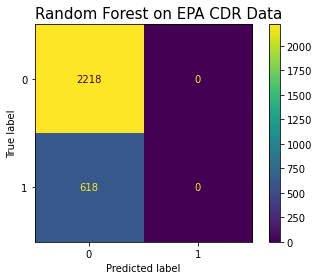

In [41]:
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.title("Random Forest on EPA CDR Data", loc="left", size =15)

In [11]:
rfdf.to_csv('data/cleaned/chemicals_small_cut_20221113.csv', index=False)

## Model 2: Exclude Harris County, TX

In [12]:
chem_sum = rfdf.groupby('CHEMICAL_NAME').sum()

In [13]:
chem_sum[chem_sum['is_rising'] == 1].shape

(1757, 1)

In [14]:
rfdf['count'] = rfdf['County-State'].map(rfdf.value_counts('County-State'))

In [15]:
no_harris = rfdf[rfdf['County-State'] != 'harris-tx'].copy()

In [16]:
no_harris.to_csv('data/cleaned/no_harris.csv', index=False)

## Model 3: Filter carcinogens

In [17]:
carcinogens = ['309-00-2','191-24-2','57-74-9','76-44-8','118-74-1','465-73-6','7439-92-1','7439-97-6','72-43-5',
               '29082-74-4','40487-42-1','608-93-5','1336-36-3','79-94-7','8001-35-2','1582-09-8']

In [18]:
rfdf['CHEMICAL_ID_NUMBER'] = everything['CHEMICAL_ID_NUMBER']
rfdf['pbt'] = [1 if x in carcinogens else 0 for x in rfdf['CHEMICAL_ID_NUMBER'].tolist()]

In [19]:
rfdf.loc[rfdf['pbt'] == 1, 'is_rising'].sum()

21

In [20]:
rising_view = rfdf.groupby('CHEMICAL_NAME')['is_rising'].count()